In [3]:
# A few tools for downloading the data
from io import StringIO
import requests
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.feature_extractor.data import Data


In [4]:
# fetch a published reconstruction 
morphology_url = "http://celltypes.brain-map.org/api/v2/well_known_file_download/491120375"
morphology_swc = StringIO(requests.get(morphology_url).text)
morphology = morphology_from_swc(morphology_swc)

# Feature functions expect a Data object - in this case just a wrapper for a Morphology
# If we were working with additional data (say, layer annotations) we would store these here as well
test_data = Data(morphology)

### Plot it real quick

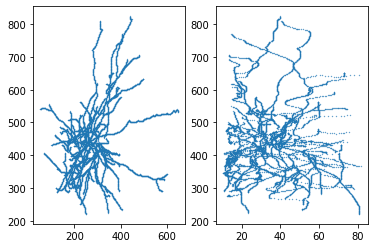

In [11]:
import matplotlib.pyplot as plt

nodes = morphology.nodes()
x = [node['x'] for node in nodes]
y = [node['y'] for node in nodes]
z = [node['z'] for node in nodes]

fig, ax = plt.subplots(1, 2)
ax[0].scatter(x, y, s=0.1)
ax[1].scatter(z, y, s=0.1)


### neuron_morphology provides a library of feature functions

In [3]:
from neuron_morphology.features.branching.outer_bifurcations import num_outer_bifurcations

num_outer_bifurcations

Signature:
num_outer_bifurcations(data: neuron_morphology.feature_extractor.data.Data, node_types: Union[List[int], NoneType] = None) -> int

Marks: ['RequiresRoot', 'BifurcationFeatures']

Help:
 Feature Extractor interface to calculate_outer_bifurcations. Returns the 
    number of bifurcations (branch points), excluding those too close to the 
    root (threshold is 1/2 the max distance from the root to any node).

    Parameters
    ----------
    data : Holds a morphology object. No additional data is required
    node_types : Restrict included nodes to these types. See 
        neuron_morphology.constants for avaiable node types. 

    

In [4]:
# we can call this just like any function
num_outer_bifurcations(test_data)

6

### Use a FeatureExtractor to run many features at once

In [7]:
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import dimension_features, intrinsic_features

extractor = FeatureExtractor()

extractor.register_features([
    num_outer_bifurcations,
    dimension_features,
    intrinsic_features
])

extractor.extract(test_data).results

/home/nileg/Desktop/neuron_morphology/neuron_morphology/feature_extractor/mark.py:118: UserWarning: This morphology is not uniquely rooted! Found 7 root nodes. Features using the root node of this morphology may not select that node consistently. Some or all of these root nodes may not be soma nodes.
  f"This morphology is not uniquely rooted! Found {num_roots} "


{'dimension_features': {'all_neurites': {'width': 598.6509,
   'height': 602.6546,
   'depth': 71.5631,
   'min_x': 51.1766,
   'min_y': 221.2187,
   'min_z': 10.1711,
   'max_x': 649.8275,
   'max_y': 823.8733,
   'max_z': 81.7342},
  'axon': {'width': 598.6509,
   'height': 602.6546,
   'depth': 71.5631,
   'min_x': 51.1766,
   'min_y': 221.2187,
   'min_z': 10.1711,
   'max_x': 649.8275,
   'max_y': 823.8733,
   'max_z': 81.7342},
  'basal_dendrite': {'width': 384.2443999999999,
   'height': 209.35199999999998,
   'depth': 58.8211,
   'min_x': 216.5112,
   'min_y': 290.8048,
   'min_z': 10.8009,
   'max_x': 600.7556,
   'max_y': 500.1568,
   'max_z': 69.622},
  'apical_dendrite': {'width': nan,
   'height': nan,
   'depth': nan,
   'min_x': nan,
   'min_y': nan,
   'min_z': nan,
   'max_x': nan,
   'max_y': nan,
   'max_z': nan}},
 'intrinsic_features': {'all_neurites': {'num_branches': 234,
   'max_branch_order': 20,
   'mean_fragmentation': 40.113122171945705,
   'num_tips': 122,


### Use specialization to run features across neurite types
... or other parameters

In [8]:
from neuron_morphology.feature_extractor.feature_specialization import NEURITE_SPECIALIZATIONS
from neuron_morphology.feature_extractor.marked_feature import specialize

extractor = FeatureExtractor()

extractor.register_features([
    specialize(num_outer_bifurcations, NEURITE_SPECIALIZATIONS),
    dimension_features,
    intrinsic_features
])

extractor.extract(test_data).results

{'basal_dendrite.num_outer_bifurcations': 2,
 'dendrite.num_outer_bifurcations': 2,
 'intrinsic_features': {'all_neurites': {'num_branches': 234,
   'max_branch_order': 20,
   'mean_fragmentation': 40.113122171945705,
   'num_tips': 122,
   'num_nodes': 9011},
  'axon': {'num_branches': 205,
   'max_branch_order': 18,
   'mean_fragmentation': 39.83076923076923,
   'num_tips': 106,
   'num_nodes': 7872},
  'basal_dendrite': {'num_branches': 28,
   'max_branch_order': 5,
   'mean_fragmentation': 45.666666666666664,
   'num_tips': 16,
   'num_nodes': 1138},
  'apical_dendrite': {'num_branches': 0,
   'max_branch_order': 0,
   'mean_fragmentation': nan,
   'num_tips': 0,
   'num_nodes': 0}},
 'dimension_features': {'all_neurites': {'width': 598.6509,
   'height': 602.6546,
   'depth': 71.5631,
   'min_x': 51.1766,
   'min_y': 221.2187,
   'min_z': 10.1711,
   'max_x': 649.8275,
   'max_y': 823.8733,
   'max_z': 81.7342},
  'axon': {'width': 598.6509,
   'height': 602.6546,
   'depth': 71.5

### It is easy to write and categorize new features

In [11]:
from neuron_morphology.feature_extractor.mark import Mark
from neuron_morphology.feature_extractor.marked_feature import marked

IsGlobal = Mark.factory("IsGlobal")
IsTrivial = Mark.factory("IsTrivial")

@marked(IsGlobal)
@marked(IsTrivial)
def num_nodes(data: Data) -> int:
    """Count the nodes!
    """
    return len(data.morphology.nodes)

num_nodes

Signature:
num_nodes(data: neuron_morphology.feature_extractor.data.Data) -> int

Marks: ['IsTrivial', 'IsGlobal']

Help:
Count the nodes!
    